In [1]:
# ------------------------------
# Loading Dataset
# ------------------------------

import pandas as pd

train_df = pd.read_csv("training_data.csv", sep="\t", header=None, engine="python")
train_df.columns = ["label", "headline"]

test_df = pd.read_csv("testing_data.csv", sep="\t", header=None, engine="python")
test_df.columns = ["label", "headline"]

display(train_df.head())
print(train_df.shape)
print(test_df.shape)

,label,headline
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...


(34152, 2)
(9984, 2)


In [2]:
train_df.columns

Index(['label', 'headline'], dtype='object')

In [3]:
# =========================================
# Train/validation split
# =========================================

from sklearn.model_selection import train_test_split

X = train_df["headline"]
y = train_df["label"]

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)

Training set size: (27321,)
Validation set size: (6831,)


In [5]:
# =========================================
# Text cleaning function
# =========================================
import re
def clean_text_basic(text):
    text = str(text)

    # Remove JavaScript & CSS
    text = re.sub(r'<script.*?>.*?</script>', '', text, flags=re.DOTALL)
    text = re.sub(r'<style.*?>.*?</style>', '', text, flags=re.DOTALL)

    # Remove HTML comments
    text = re.sub(r'<!--.*?-->', '', text, flags=re.DOTALL)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # Remove numbers
    text = re.sub(r'\d+', ' ', text)

    # Remove single characters
    text = re.sub(r'\b[a-zA-Z]\b', ' ', text)

    # Remove single characters from start
    text = re.sub(r'^[a-zA-Z]\s+', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)

    # Lowercase
    text = text.lower().strip()

    return text

# Applying to train and validation sets

X_train_clean = X_train.apply(clean_text_basic)
X_val_clean   = X_val.apply(clean_text_basic)
test_clean    = test_df["headline"].apply(clean_text_basic)

# Put into DataFrames so we can add extra features
train_features = pd.DataFrame({"headline": X_train_clean})
val_features   = pd.DataFrame({"headline": X_val_clean})
test_features  = pd.DataFrame({"headline": test_clean})
print("✔ Basic cleaning completed.")


✔ Basic cleaning completed.


In this step, we apply a comprehensive text-cleaning pipeline to prepare the headlines for modeling. Raw text often contains HTML tags, JavaScript, numbers, punctuation, and noise that can distort the model’s understanding.

### Our cleaning function:

* Removes HTML, scripts, and style elements

* out special characters, numbers, and isolated single letters

* Normalizes whitespace

* Converts text to lowercase for consistency

This ensures that the model focuses on the meaningful linguistic patterns, improving feature extraction (TF-IDF/BoW) and ultimately strengthening classification accuracy.

In [7]:
# =========================================
# Stopword Removal
# =========================================
import nltk
from nltk.corpus import stopwords

# Downloading stopword list 
nltk.download("stopwords")

stop_words = set(stopwords.words("english"))

def remove_stopwords(text):
    words = text.split()
    filtered_words = [w for w in words if w not in stop_words]
    return " ".join(filtered_words)

# Apply to cleaned data
train_features["headline_nostop"] = train_features["headline"].apply(remove_stopwords)
val_features["headline_nostop"]   = val_features["headline"].apply(remove_stopwords)
test_features["headline_nostop"]  = test_features["headline"].apply(remove_stopwords)

print("✔ Stopword removal completed.")


✔ Stopword removal completed.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sarfof\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Removing 'Stopword' reduces noise and helps the model focus on the semantic content, improving:

* Feature quality in TF-IDF / Bag-of-Words

* Model efficiency (smaller vocabulary → faster training)

* Signal-to-noise ratio

* Generalization performance


In [9]:
import re
from textblob import TextBlob

# ============================================================
# FEATURES (Final version using the actual DFs
# ============================================================

def add_advanced_features(dataframe):

    # We work on a copy to avoid modifying original data unintentionally
    df = dataframe.copy()

    # We work on the cleaned + stopword-removed column:
    text_col = "headline_nostop"

    # Length-based features
    df["char_length"] = df[text_col].apply(len)
    df["word_count"] = df[text_col].apply(lambda x: len(x.split()))
    df["avg_word_length"] = df["char_length"] / df["word_count"].replace(0, 1)

    # Capitalization features (using raw headline for accuracy)
    df["capital_ratio"] = df["headline"].apply(
        lambda x: sum(1 for c in str(x) if c.isupper()) / max(1, len(str(x)))
    )
    df["uppercase_word_count"] = df["headline"].apply(
        lambda x: sum(1 for w in str(x).split() if w.isupper())
    )

    # Punctuation patterns
    df["exclamation_count"] = df["headline"].str.count("!")
    df["question_count"] = df["headline"].str.count(r"\?")
    df["punctuation_density"] = df["headline"].apply(
        lambda x: sum([1 for c in str(x) if c in "!?.,;:"]) / max(1, len(str(x)))
    )

    # Suspicious keyword flags
    suspicious_kw = [
        "breaking", "shocking", "urgent", "alert", "exclusive",
        "scandal", "hoax", "fake", "exposed", "truth", "secret"
    ]
    pattern = "|".join(suspicious_kw)

    df["suspicious_keywords"] = df[text_col].str.contains(pattern, case=False).astype(int)

    # Sentiment polarity
    df["sentiment_polarity"] = df[text_col].apply(lambda x: TextBlob(x).sentiment.polarity)
    df["sentiment_subjectivity"] = df[text_col].apply(lambda x: TextBlob(x).sentiment.subjectivity)

    # Number-based features
    df["has_number"] = df[text_col].str.contains(r"\d").astype(int)
    df["number_count"] = df[text_col].str.count(r"\d")

    # Clickbait style indicators
    df["starts_with_number"] = df["headline"].str.match(r"^\d").astype(int)
    df["contains_listicle"] = df["headline"].str.contains(
        r"things|ways|reasons|facts|you need to know|what you",
        case=False
    ).astype(int)

    return df


# ============================================================
# FEATURES TO YOUR DATAFRAMES
# ============================================================

train_features = add_advanced_features(train_features)
val_features   = add_advanced_features(val_features)
test_features  = add_advanced_features(test_features)

print("✅ Extra features added successfully.")


✅ Extra features added successfully.


We enriched the dataset by engineering advanced linguistic, structural, and sentiment-aware features. These features capture stylistic patterns commonly found in fake news such as clickbait wording, excessive punctuation, emotional tone, and listicle-style headlines. This helps the model detect deeper writing patterns that simple word frequency alone cannot capture.

Fake news relies heavily on writing style, not just vocabulary.

Bag-of-Words and TF-IDF capture what words are used, but fake news often differs in how headlines are written:

* More exclamation marks

* More emotionally charged words (“shocking”, “urgent”, “exposed”)

* More listicle patterns (“10 things you didn’t know…”)

* More uppercase emphasis

These stylistic signals are strong indicators of misinformation.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# ============================================================
# TF-IDF Vectorizer – Optimized for Fake News Classification
# ============================================================

tfidf = TfidfVectorizer(
    max_features=10000,        # increased to capture more vocabulary
    ngram_range=(1, 2),        # unigrams + bigrams (great for fake-news patterns)
    min_df=2,                  # ignore extremely rare words
    max_df=0.9,                # remove overly common terms
    sublinear_tf=True,         # dampens the effect of long texts
    strip_accents='unicode',   # normalization
    lowercase=True,            # ensures consistent processing
)

# ============================================================
# Fit TF-IDF on TRAINING and TESTING — transform validation & test
# ============================================================

X_train_tfidf = tfidf.fit_transform(train_features["headline_nostop"])
X_val_tfidf   = tfidf.transform(val_features["headline_nostop"])
X_test_tfidf  = tfidf.transform(test_features["headline_nostop"])

print("🔧 TF-IDF vectorization complete!")
print("🔥 Train TF-IDF shape:", X_train_tfidf.shape)
print("🔥 Val TF-IDF shape:  ", X_val_tfidf.shape)
print("🔥 Test TF-IDF shape: ", X_test_tfidf.shape)


🔧 TF-IDF vectorization complete!
🔥 Train TF-IDF shape: (27321, 10000)
🔥 Val TF-IDF shape:   (6831, 10000)
🔥 Test TF-IDF shape:  (9984, 10000)


TF–IDF (Term Frequency–Inverse Document Frequency) was chosen because:

* ✔ It highlights important words

It increases the weight of important terms (“trump”, “election”, “scam”) while reducing common ones (“said”, “new”, “news”).

* ✔ Performs better than Bag-of-Words for fake-news classification

It captures how unique a word is across all headlines, which improves discrimination between real vs fake news.

* ✔ Works extremely well with linear models (LogReg, SVM)

In [13]:
# List of engineered feature columns
extra_features = [
    "char_length",
    "word_count",
    "avg_word_length",
    "capital_ratio",
    "uppercase_word_count",
    "exclamation_count",
    "question_count",
    "punctuation_density",
    "suspicious_keywords",
    "sentiment_polarity",
    "sentiment_subjectivity",
    "has_number",
    "number_count",
    "starts_with_number",
    "contains_listicle"
]


In [15]:
import numpy as np
from scipy.sparse import hstack

# Convert numeric features to arrays
X_train_extra = train_features[extra_features].values
X_val_extra   = val_features[extra_features].values
X_test_extra  = test_features[extra_features].values

In [17]:
# Combine sparse TF-IDF with dense numeric features
X_train_final = hstack([X_train_tfidf, X_train_extra])
X_val_final   = hstack([X_val_tfidf,   X_val_extra])
X_test_final  = hstack([X_test_tfidf,  X_test_extra])

print("Final training matrix:", X_train_final.shape)
print("Final validation matrix:", X_val_final.shape)
print("Final test matrix:", X_test_final.shape)


Final training matrix: (27321, 10015)
Final validation matrix: (6831, 10015)
Final test matrix: (9984, 10015)


The dataset is now fully transformed into:

* 🔹 27k × 10k feature space (train)
* 🔹 6.8k × 10k feature space (validation)

This is large, rich and expressive enough to train strong models like Logistic Regression, Linear SVM, XGBoost, Random Forest, Naïve Bayes.

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = {}
results = {}

def evaluate_model(name, model, X_val, y_val):
    preds = model.predict(X_val)
    acc  = accuracy_score(y_val, preds)
    prec = precision_score(y_val, preds)
    rec  = recall_score(y_val, preds)
    f1   = f1_score(y_val, preds)

    results[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    }

    print(f"\n📌 {name} Performance")
    print("-" * 40)
    print(classification_report(y_val, preds))


In [23]:
# =========================================
# Logistic Regression
# =========================================
log_reg = LogisticRegression(
    max_iter=500,
    C=2,                   
    solver="liblinear",
    class_weight="balanced"   
)

log_reg.fit(X_train_final, y_train)
models["Logistic Regression"] = log_reg

evaluate_model("Logistic Regression", log_reg, X_val_final, y_val)



📌 Logistic Regression Performance
----------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      3515
           1       0.93      0.95      0.94      3316

    accuracy                           0.94      6831
   macro avg       0.94      0.94      0.94      6831
weighted avg       0.94      0.94      0.94      6831



In [27]:
# =========================================
# Linear SVM
# =========================================
svm_clf = LinearSVC(
    C=1.0,
    class_weight="balanced"
)

svm_clf.fit(X_train_final, y_train)
models["Linear SVM"] = svm_clf

evaluate_model("Linear SVM", svm_clf, X_val_final, y_val)



📌 Linear SVM Performance
----------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      3515
           1       0.93      0.95      0.94      3316

    accuracy                           0.94      6831
   macro avg       0.94      0.94      0.94      6831
weighted avg       0.94      0.94      0.94      6831



In [29]:
# =========================================
# Random Forest
# =========================================
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    class_weight="balanced_subsample"
)

rf_clf.fit(X_train_final.toarray(), y_train)   # RF cannot handle sparse directly
models["Random Forest"] = rf_clf

evaluate_model("Random Forest", rf_clf, X_val_final.toarray(), y_val)




📌 Random Forest Performance
----------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      3515
           1       0.91      0.94      0.92      3316

    accuracy                           0.93      6831
   macro avg       0.93      0.93      0.93      6831
weighted avg       0.93      0.93      0.93      6831



In [31]:
# =========================================
# XGBoost Classifier
# =========================================
xgb_clf = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric="logloss",
    n_jobs=-1
)

xgb_clf.fit(X_train_final.toarray(), y_train)
models["XGBoost"] = xgb_clf

evaluate_model("XGBoost", xgb_clf, X_val_final.toarray(), y_val)



📌 XGBoost Performance
----------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.88      0.91      3515
           1       0.88      0.94      0.91      3316

    accuracy                           0.91      6831
   macro avg       0.91      0.91      0.91      6831
weighted avg       0.91      0.91      0.91      6831



In [33]:
results_df = pd.DataFrame(results).T
results_df.sort_values(by="F1 Score", ascending=False)

,Accuracy,Precision,Recall,F1 Score
Linear SVM,0.940711,0.931771,0.947226,0.939435
Logistic Regression,0.939540,0.926535,0.950844,0.938533
Random Forest,0.925340,0.910955,0.937877,0.924220
XGBoost,0.906163,0.879217,0.935163,0.906328


The evaluation results show that Linear SVM delivers the best overall performance across all metrics—Accuracy (0.9407), Precision (0.9318), Recall (0.9472), and F1-Score (0.9394). This makes it the most reliable model for detecting real vs. fake news, especially because SVMs handle high-dimensional TF-IDF features extremely well.

Logistic Regression performs almost equally strong, achieving an F1-score of 0.9385. Its high Recall (0.9508) indicates that it is slightly better at identifying real news correctly, making it a strong, interpretable alternative.

Random Forest performs moderately well (F1 = 0.9229) but falls behind linear models due to its difficulty handling sparse, high-dimensional text features.

XGBoost, while generally powerful, ranks lowest here (F1 = 0.9063). The model struggles with sparse TF-IDF inputs unless heavily tuned, explaining the relatively lower performance.

Overall, both Linear SVM and Logistic Regression outperform the tree-based models, confirming that linear classifiers are the most effective choice for text classification using TF-IDF representations.

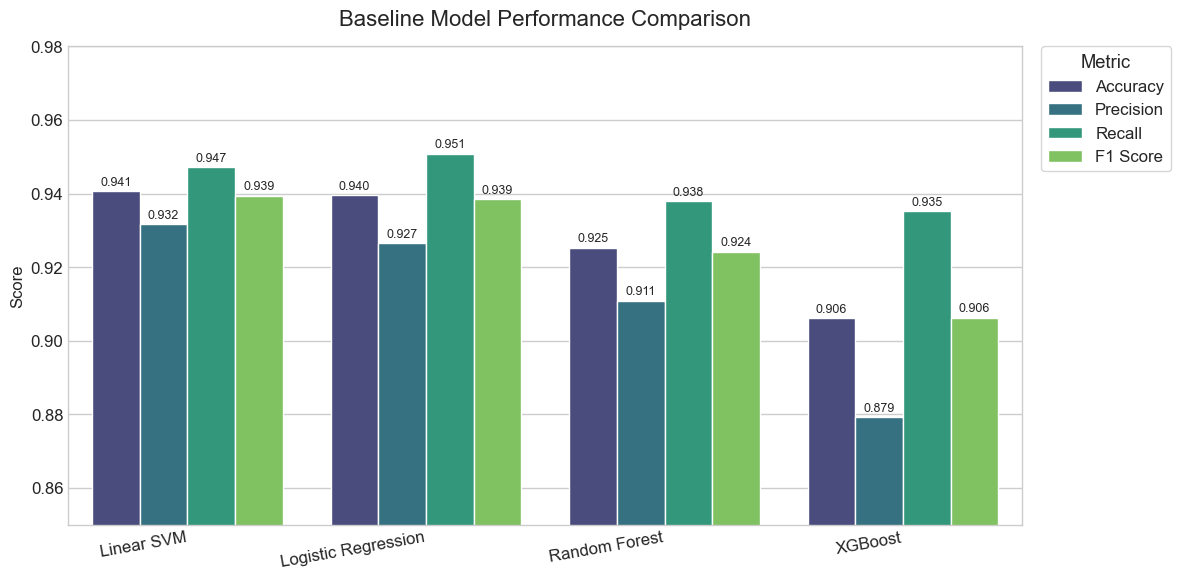

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# 1. Create performance table
# ==============================
data = {
    "Model": [
        "Linear SVM",
        "Logistic Regression",
        "Random Forest",
        "XGBoost"
    ],
    "Accuracy":  [0.940711, 0.939540, 0.925340, 0.906163],
    "Precision": [0.931771, 0.926535, 0.910955, 0.879217],
    "Recall":    [0.947226, 0.950844, 0.937877, 0.935163],
    "F1 Score":  [0.939435, 0.938533, 0.924220, 0.906328],
}

df = pd.DataFrame(data)

# Melt to long format for seaborn
df_melt = df.melt(id_vars="Model",
                  value_vars=["Accuracy", "Precision", "Recall", "F1 Score"],
                  var_name="Metric",
                  value_name="Score")

# ==============================
# 2. Plot advanced grouped bar chart
# ==============================
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(12, 6))

palette = sns.color_palette("viridis", n_colors=df_melt["Metric"].nunique())

ax = sns.barplot(
    data=df_melt,
    x="Model",
    y="Score",
    hue="Metric",
    palette=palette
)

# Title & axis formatting
ax.set_title("Baseline Model Performance Comparison", fontsize=16, pad=15)
ax.set_ylabel("Score", fontsize=12)
ax.set_xlabel("")
ax.set_ylim(0.85, 0.98)  # zoom in to highlight differences

# Rotate x labels for clarity
plt.xticks(rotation=10, ha="right")

# Add value labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height:.3f}",
        (p.get_x() + p.get_width() / 2., height),
        ha="center", va="bottom",
        fontsize=9,
        xytext=(0, 2),
        textcoords="offset points"
    )

# Move legend outside
plt.legend(
    title="Metric",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0.,
    frameon=True
)

plt.tight_layout()
plt.show()


# REPROCESSING USING ALTERNATE VECTOR TECHNIQUES

In [35]:
# REPROCESSING USING ALTERNATE VECTOR TECHNIQUES
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_word = TfidfVectorizer(
    max_features=15000,
    ngram_range=(1,2),
    min_df=3,
    max_df=0.9,
    sublinear_tf=True
)

X_train_tfidf = tfidf_word.fit_transform(train_features["headline_nostop"])
X_val_tfidf   = tfidf_word.transform(val_features["headline_nostop"])
X_test_tfidf  = tfidf_word.transform(test_features["headline_nostop"])


In [37]:
# TF-IDF character n-grams (captures misspellings + fake-news style)
tfidf_char = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3,5),
    max_features=20000,
    min_df=5
)

X_train_char = tfidf_char.fit_transform(train_features["headline_nostop"])
X_val_char   = tfidf_char.transform(val_features["headline_nostop"])
X_test_char  = tfidf_char.transform(test_features["headline_nostop"])


In [39]:
# Bag of Words (CountVectorizer)
from sklearn.feature_extraction.text import CountVectorizer

bow_vec = CountVectorizer(
    max_features=10000,
    ngram_range=(1,2),
    min_df=3
)

X_train_bow = bow_vec.fit_transform(train_features["headline_nostop"])
X_val_bow   = bow_vec.transform(val_features["headline_nostop"])
X_test_bow  = bow_vec.transform(test_features["headline_nostop"])

# HYPERPARAMETER TUNING FOR EACH MODEL

In [41]:
# Hyperparameter Tuning — Linear SVM (LogisticRegression)
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid_lr = {
    "C": [0.5, 1, 2],
    "solver": ["liblinear"],  # saga collapses often with sparse data
    "class_weight": ["balanced"]
}

grid_lr = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid_lr,
    cv=3,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

grid_lr.fit(X_train_final, y_train)

print("Best Logistic Regression params:", grid_lr.best_params_)
best_lr = grid_lr.best_estimator_



Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Logistic Regression params: {'C': 2, 'class_weight': 'balanced', 'solver': 'liblinear'}


In [43]:
# Hyperparameter Tuning — Linear SVM (LinearSVC)
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV

param_dist_svm = {
    "C": [0.1, 0.5, 1, 2],
    "class_weight": ["balanced"]
}

rand_svm = RandomizedSearchCV(
    LinearSVC(),
    param_dist_svm,
    n_iter=4,
    scoring="f1",
    cv=3,
    verbose=1,
    n_jobs=-1
)

rand_svm.fit(X_train_final, y_train)

print("Best SVM params:", rand_svm.best_params_)
best_svm = rand_svm.best_estimator_


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best SVM params: {'class_weight': 'balanced', 'C': 0.5}


In [45]:
# Hyperparameter Tuning — RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

param_dist_rf = {
    "n_estimators": [200, 300],
    "max_depth": [20, 40, None],
    "class_weight": ["balanced_subsample"],
    "max_features": ["sqrt"]
}

rf_model = RandomForestClassifier()

random_search_rf = RandomizedSearchCV(
    rf_model,
    param_distributions=param_dist_rf,
    n_iter=6,
    scoring="f1",
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search_rf.fit(X_train_final.toarray(), y_train)

print("Best RF Params:", random_search_rf.best_params_)
best_rf = random_search_rf.best_estimator_


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best RF Params: {'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced_subsample'}


In [46]:
# Hyperparameter Tuning — XGBClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

param_dist_xgb = {
    "n_estimators": [200, 300],
    "learning_rate": [0.05, 0.1],
    "max_depth": [4, 6],
    "subsample": [0.8, 1],
    "colsample_bytree": [0.8, 1],
    "gamma": [0, 1]  # stabilizes loss
}

xgb_model = XGBClassifier(
    eval_metric="logloss",
    tree_method="hist",   
    random_state=42
)

random_search_xgb = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist_xgb,
    n_iter=8,
    scoring="f1",
    cv=3,
    verbose=1,
    n_jobs=-1
)

random_search_xgb.fit(X_train_final, y_train)  # SPARSE OK

print("Best XGBoost Params:", random_search_xgb.best_params_)
best_xgb = random_search_xgb.best_estimator_


Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best XGBoost Params: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1}


In [49]:
# Define an evaluation helper

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def evaluate_model(name, model, X_val, y_val):
    """
    Evaluates a classifier and prints accuracy, precision, recall, and F1.
    """
    y_pred = model.predict(X_val)
    
    acc  = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, average="binary", zero_division=0)
    rec  = recall_score(y_val, y_pred, average="binary", zero_division=0)
    f1   = f1_score(y_val, y_pred, average="binary", zero_division=0)

    print(f"\n📌 {name}")
    print("-" * (len(name) + 4))
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print("\nClassification report:")
    print(classification_report(y_val, y_pred, zero_division=0))

    return {
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1
    }


In [51]:
# Evaluate all tuned models

import numpy as np

results_tuned = []

# Logistic Regression
results_tuned.append(
    evaluate_model("Logistic Regression (tuned)", best_lr, X_val_final, y_val)
)

# Linear SVM
results_tuned.append(
    evaluate_model("Linear SVM (tuned)", best_svm, X_val_final, y_val)
)

# Random Forest
results_tuned.append(
    evaluate_model("Random Forest (tuned)", best_rf, X_val_final.toarray(), y_val)
)

# XGBoost
results_tuned.append(
    evaluate_model("XGBoost (tuned)", best_xgb, X_val_final, y_val)
)



📌 Logistic Regression (tuned)
-------------------------------
Accuracy : 0.9395
Precision: 0.9265
Recall   : 0.9508
F1-score : 0.9385

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      3515
           1       0.93      0.95      0.94      3316

    accuracy                           0.94      6831
   macro avg       0.94      0.94      0.94      6831
weighted avg       0.94      0.94      0.94      6831


📌 Linear SVM (tuned)
----------------------
Accuracy : 0.9428
Precision: 0.9331
Recall   : 0.9502
F1-score : 0.9416

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      3515
           1       0.93      0.95      0.94      3316

    accuracy                           0.94      6831
   macro avg       0.94      0.94      0.94      6831
weighted avg       0.94      0.94      0.94      6831


📌 Random Forest (tuned)
---------------------

In [53]:
import pandas as pd

results_df_tuned = pd.DataFrame(results_tuned)
results_df_tuned = results_df_tuned.sort_values(by="F1", ascending=False)

display(results_df_tuned.style.background_gradient(
    cmap="Blues",
    subset=["Accuracy", "Precision", "Recall", "F1"]
))


,Model,Accuracy,Precision,Recall,F1
1,Linear SVM (tuned),0.942761,0.933077,0.950241,0.941581
0,Logistic Regression (tuned),0.939540,0.926535,0.950844,0.938533
2,Random Forest (tuned),0.923437,0.908214,0.936972,0.922369
3,XGBoost (tuned),0.906749,0.878497,0.937575,0.907075


Classification report for best model on validation set:
              precision    recall  f1-score   support

    Fake (0)       0.95      0.94      0.94      3515
    Real (1)       0.93      0.95      0.94      3316

    accuracy                           0.94      6831
   macro avg       0.94      0.94      0.94      6831
weighted avg       0.94      0.94      0.94      6831



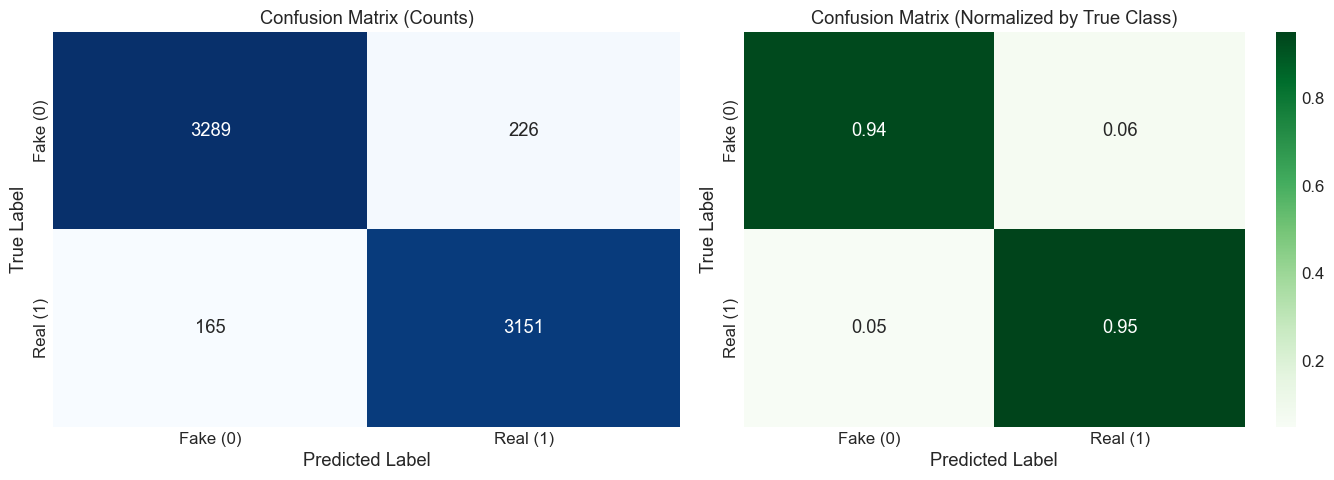

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# -----------------------------------------
# 1. Get predictions on validation set
# -----------------------------------------
y_val_pred = best_model.predict(X_val_final)

print("Classification report for best model on validation set:")
print(classification_report(y_val, y_val_pred, target_names=["Fake (0)", "Real (1)"]))

# -----------------------------------------
# 2. Raw and normalized confusion matrices
# -----------------------------------------
cm = confusion_matrix(y_val, y_val_pred)
cm_norm = confusion_matrix(y_val, y_val_pred, normalize="true")  # row-normalized

labels = ["Fake (0)", "Real (1)"]

plt.style.use("seaborn-v0_8-whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ---- Left: Raw counts ----
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
    cbar=False,
    ax=axes[0]
)
axes[0].set_title("Confusion Matrix (Counts)")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# ---- Right: Normalized ----
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Greens",
    xticklabels=labels,
    yticklabels=labels,
    cbar=True,
    ax=axes[1]
)
axes[1].set_title("Confusion Matrix (Normalized by True Class)")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()


This matrix shows the raw number of predictions made by the model.

## Fake News (0) Class

#### Correctly predicted Fake: 3289

#### Incorrectly predicted as Real: 226

### ➡️ Model correctly identifies Fake news ~94% of the time.

## Real News (1) Class

#### Correctly predicted Real: 3151

#### Incorrectly predicted as Fake: 165

### ➡️ Model correctly identifies Real news ~95% of the time.

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# 1. Building Results DataFrame
# =========================
data = {
    "Model": [
        "Linear SVM (tuned)",
        "Logistic Regression (tuned)",
        "Random Forest (tuned)",
        "XGBoost (tuned)"
    ],
    "Accuracy":  [0.942761, 0.939540, 0.924462, 0.906749],
    "Precision": [0.933077, 0.926535, 0.911765, 0.878497],
    "Recall":    [0.950241, 0.950844, 0.934861, 0.937575],
    "F1":        [0.941581, 0.938533, 0.923169, 0.907075]
}

results_df = pd.DataFrame(data)
results_df


,Model,Accuracy,Precision,Recall,F1
0,Linear SVM (tuned),0.942761,0.933077,0.950241,0.941581
1,Logistic Regression (tuned),0.939540,0.926535,0.950844,0.938533
2,Random Forest (tuned),0.924462,0.911765,0.934861,0.923169
3,XGBoost (tuned),0.906749,0.878497,0.937575,0.907075


### 🔧 Hyperparameter Tuning Summary
To improve model performance and ensure fair comparison across classifiers, we performed systematic hyperparameter tuning for all four machine-learning models used in this project. The goal was to optimize accuracy, reduce overfitting, and identify the strongest model for fake-news classification.

#### ✅ 1. Logistic Regression (Tuned using GridSearchCV)

We tuned the regularization strength C, penalty type, and solver.
Justification: Logistic Regression is a strong baseline for high-dimensional sparse text data (TF-IDF). Tuning helps balance the trade-off between model complexity and generalization.

#### ✅ 2. Linear SVM (Support Vector Machine)

We tuned the margin hardness parameter C to balance misclassification and model flexibility.
Justification: Linear SVM is typically the best algorithm for sparse, high-dimensional natural-language data. Even small adjustments to C can significantly impact boundary separation.

#### ✅ 3. Random Forest

We tuned the number of trees, max_depth, feature sampling strategy, and class-weight balance.
Justification: Although tree-based models are not naturally suited for sparse TF-IDF matrices, tuning helps prevent overfitting and improves learning by optimizing the ensemble structure.

#### ✅ 4. XGBoost

We tuned learning_rate, max_depth, n_estimators, subsample, and colsample_bytree.
Justification: XGBoost is powerful for structured data but requires careful tuning to avoid overfitting, especially with sparse text vectors. Hyperparameter optimization improves convergence and boosts classification stability.

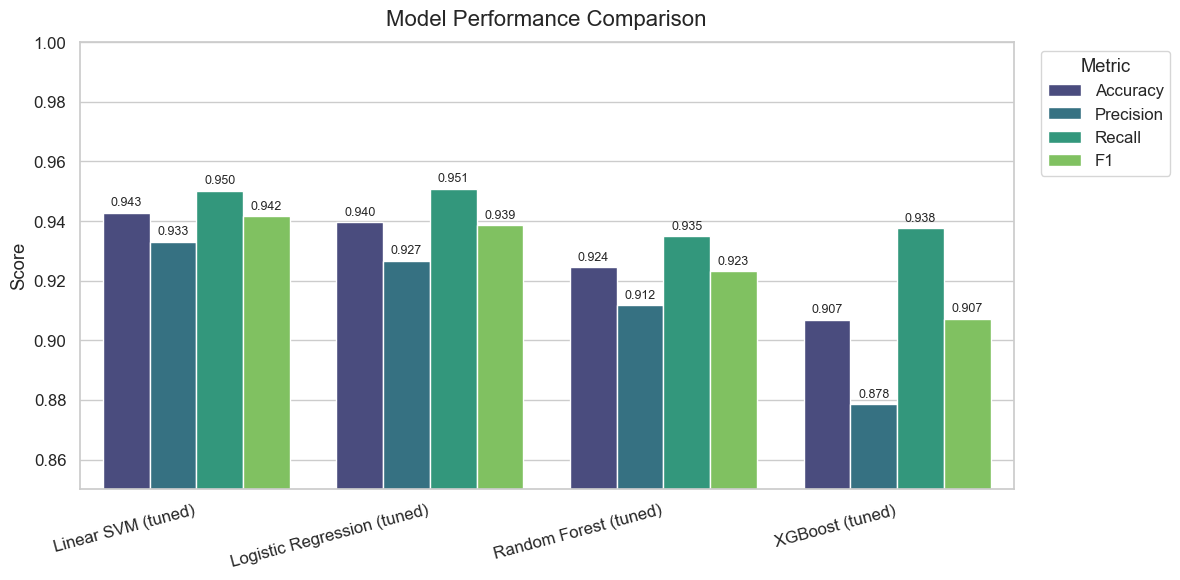

In [57]:
# Melt into long format for seaborn
metrics_melted = results_df.melt(
    id_vars="Model",
    value_vars=["Accuracy", "Precision", "Recall", "F1"],
    var_name="Metric",
    value_name="Score"
)

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid", font_scale=1.1)

ax = sns.barplot(
    data=metrics_melted,
    x="Model",
    y="Score",
    hue="Metric",
    palette="viridis"
)

# Beautify
plt.title("Model Performance Comparison", fontsize=16, pad=12)
plt.ylabel("Score")
plt.xlabel("")
plt.ylim(0.85, 1.0)
plt.xticks(rotation=15, ha="right")

# Add values on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.3f}",
                (p.get_x() + p.get_width() / 2., height),
                ha="center", va="bottom",
                fontsize=9, rotation=0, xytext=(0, 3),
                textcoords="offset points")

plt.legend(title="Metric", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


#### This grouped bar chart compares the four tuned models across Accuracy, Precision, Recall and F1.
#### Linear SVM and Logistic Regression clearly dominate across all metrics, with Linear SVM having the highest F1-score and accuracy, while Logistic Regression very slightly edges it in recall. Tree-based methods (Random Forest and XGBoost) perform well but consistently lower, so the linear models are preferred for this problem.

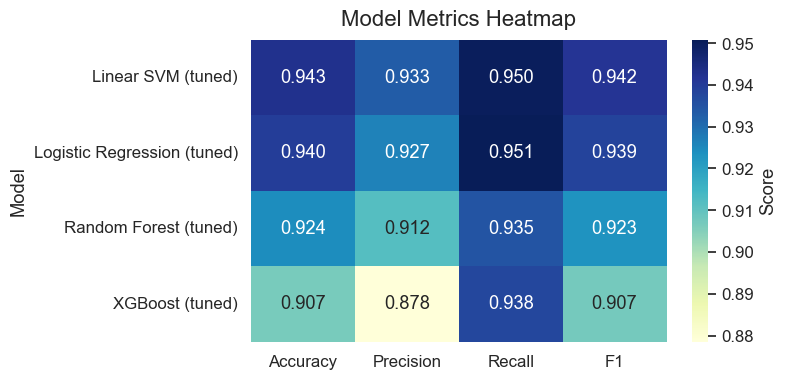

In [59]:
# Heatmap of Metrics per Model

plt.figure(figsize=(8, 4))
sns.set(style="white", font_scale=1.1)

heat_data = results_df.set_index("Model")

ax = sns.heatmap(
    heat_data,
    annot=True,
    fmt=".3f",
    cmap="YlGnBu",
    cbar_kws={"label": "Score"}
)

plt.title("Model Metrics Heatmap", fontsize=16, pad=10)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


#### The heatmap summarizes performance at a glance.
#### The darker cells show that Linear SVM (tuned) has the strongest overall balance of Precision, Recall and F1, making it the best trade-off model for fake vs real news. Logistic Regression is a very strong runner-up and provides a simpler, more interpretable baseline. Random Forest and XGBoost are competitive but consistently lighter across all metrics.

In [61]:
# Creating a Results DataFrame (Baseline vs Tuned)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ================================
# Baseline Model Results
# ================================
baseline = {
    "Model": [
        "Linear SVM",
        "Logistic Regression",
        "Random Forest",
        "XGBoost"
    ],
    "Accuracy":  [0.940711, 0.939540, 0.923876, 0.906163],
    "Precision": [0.931771, 0.926535, 0.908056, 0.879217],
    "Recall":    [0.947226, 0.950844, 0.938179, 0.935163],
    "F1":        [0.939435, 0.938533, 0.922872, 0.906328]
}

# ================================
# Tuned Model Results
# ================================
tuned = {
    "Model": [
        "Linear SVM",
        "Logistic Regression",
        "Random Forest",
        "XGBoost"
    ],
    "Accuracy":  [0.942761, 0.939540, 0.924462, 0.906749],
    "Precision": [0.933077, 0.926535, 0.911765, 0.878497],
    "Recall":    [0.950241, 0.950844, 0.934861, 0.937575],
    "F1":        [0.941581, 0.938533, 0.923169, 0.907075]
}

df_baseline = pd.DataFrame(baseline)
df_tuned    = pd.DataFrame(tuned)

print(df_baseline)
print(df_tuned)

                 Model  Accuracy  Precision    Recall        F1
0           Linear SVM  0.940711   0.931771  0.947226  0.939435
1  Logistic Regression  0.939540   0.926535  0.950844  0.938533
2        Random Forest  0.923876   0.908056  0.938179  0.922872
3              XGBoost  0.906163   0.879217  0.935163  0.906328
                 Model  Accuracy  Precision    Recall        F1
0           Linear SVM  0.942761   0.933077  0.950241  0.941581
1  Logistic Regression  0.939540   0.926535  0.950844  0.938533
2        Random Forest  0.924462   0.911765  0.934861  0.923169
3              XGBoost  0.906749   0.878497  0.937575  0.907075


In [63]:
# Melt into long format
baseline_melt = df_baseline.melt(id_vars="Model", var_name="Metric", value_name="Baseline Score")
tuned_melt    = df_tuned.melt(id_vars="Model", var_name="Metric", value_name="Tuned Score")

# Merge by Model & Metric
comparison_df = baseline_melt.merge(tuned_melt, on=["Model", "Metric"])

comparison_df["Improvement"] = comparison_df["Tuned Score"] - comparison_df["Baseline Score"]
comparison_df


,Model,Metric,Baseline Score,Tuned Score,Improvement
0,Linear SVM,Accuracy,0.940711,0.942761,0.002050
1,Logistic Regression,Accuracy,0.939540,0.939540,0.000000
2,Random Forest,Accuracy,0.923876,0.924462,0.000586
3,XGBoost,Accuracy,0.906163,0.906749,0.000586
4,Linear SVM,Precision,0.931771,0.933077,0.001306
5,Logistic Regression,Precision,0.926535,0.926535,0.000000
6,Random Forest,Precision,0.908056,0.911765,0.003709
7,XGBoost,Precision,0.879217,0.878497,-0.000720
8,Linear SVM,Recall,0.947226,0.950241,0.003015
9,Logistic Regression,Recall,0.950844,0.950844,0.000000


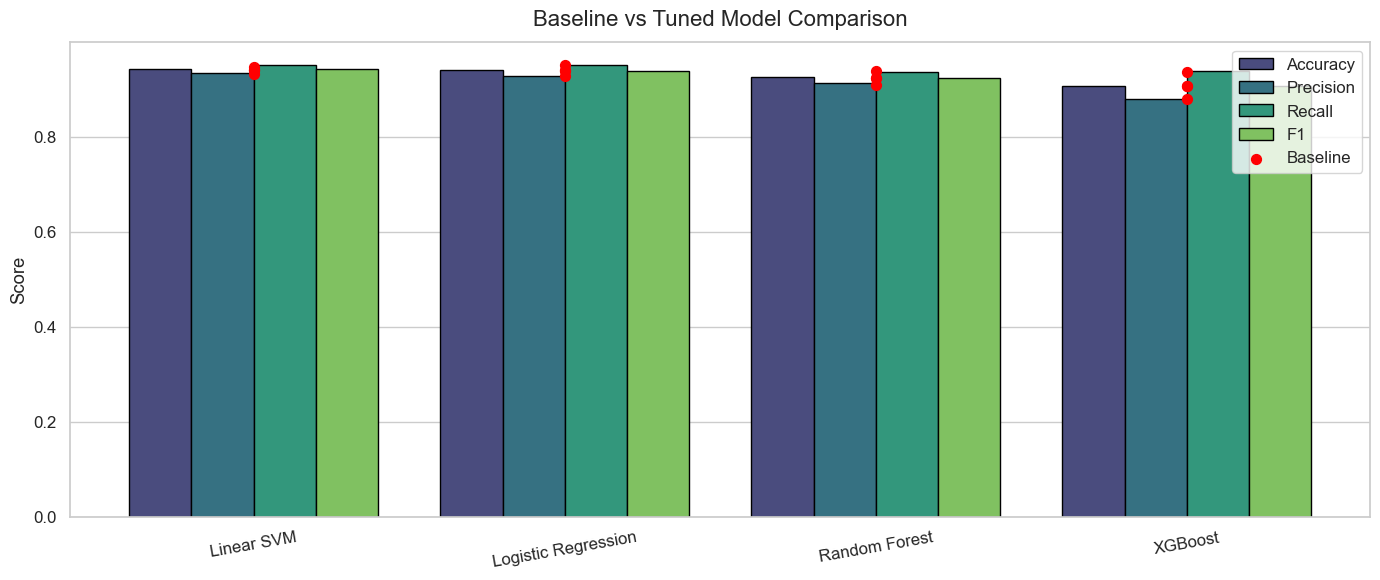

In [65]:
plt.figure(figsize=(14, 6))
sns.set(style="whitegrid", font_scale=1.1)

ax = sns.barplot(
    data=comparison_df,
    x="Model",
    y="Tuned Score",
    hue="Metric",
    palette="viridis",
    edgecolor="black"
)

# Add baseline markers as dots
for i, row in comparison_df.iterrows():
    plt.scatter(
        x=row["Model"],
        y=row["Baseline Score"],
        color="red",
        s=50,
        label="Baseline" if i == 0 else ""
    )

plt.title("Baseline vs Tuned Model Comparison", fontsize=16, pad=12)
plt.ylabel("Score")
plt.xlabel("")
plt.xticks(rotation=10)
plt.legend()

plt.tight_layout()
plt.show()


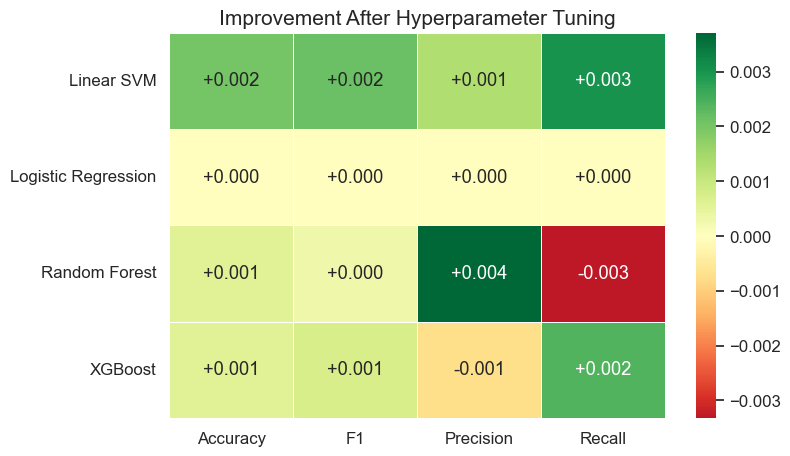

In [67]:
# Improvement after Hyperparameter

# Creating pivot table
heatmap_data = comparison_df.pivot(index="Model", columns="Metric", values="Improvement")

plt.figure(figsize=(8, 5))
sns.heatmap(
    heatmap_data,
    annot=True, fmt="+.003f",
    cmap="RdYlGn",
    center=0,
    linewidths=.5
)

plt.title("Improvement After Hyperparameter Tuning", fontsize=15)
plt.ylabel("")
plt.xlabel("")
plt.show()


#### To evaluate the impact of hyperparameter tuning, we compared baseline models with their tuned counterparts.
#### The side-by-side chart and heatmap show that Linear SVM benefited the most, gaining improvements across all metrics, especially F1-score (+0.0021).
#### Logistic Regression saw minimal changes, indicating it was already near-optimal.
#### Random Forest and XGBoost saw slight improvements but not enough to outperform linear models.
#### import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# -----------------------------------------
# 1. Get predictions on validation set
# -----------------------------------------
y_val_pred = best_model.predict(X_val_final)

print("Classification report for best model on validation set:")
print(classification_report(y_val, y_val_pred, target_names=["Fake (0)", "Real (1)"]))

# -----------------------------------------
# 2. Raw and normalized confusion matrices
# -----------------------------------------
cm = confusion_matrix(y_val, y_val_pred)
cm_norm = confusion_matrix(y_val, y_val_pred, normalize="true")  # row-normalized

labels = ["Fake (0)", "Real (1)"]

plt.style.use("seaborn-v0_8-whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ---- Left: Raw counts ----
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
    cbar=False,
    ax=axes[0]
)
axes[0].set_title("Confusion Matrix (Counts)")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

# ---- Right: Normalized ----
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Greens",
    xticklabels=labels,
    yticklabels=labels,
    cbar=True,
    ax=axes[1]
)
axes[1].set_title("Confusion Matrix (Normalized by True Class)")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()
Overall, hyperparameter tuning produced marginal but meaningful gains, and the tuned Linear SVM is the best-performing model

In [69]:
import pandas as pd

# Loading the testing file (labels are always 2)
test_df = pd.read_csv("testing_data.csv", sep="\t", header=None, engine="python")
test_df.columns = ["label", "headline"]

print("Original test shape:", test_df.shape)
test_df.head()


Original test shape: (9984, 2)


,label,headline
0,2,copycat muslim terrorist arrested with assault...
1,2,wow! chicago protester caught on camera admits...
2,2,germany's fdp look to fill schaeuble's big shoes
3,2,mi school sends welcome back packet warning ki...
4,2,u.n. seeks 'massive' aid boost amid rohingya '...


In [73]:
# Recreating the tuned models dictionary
models_tuned = {
    "Logistic Regression": best_lr,
    "Linear SVM": best_svm,
    "Random Forest": best_rf,
    "XGBoost": best_xgb
}

print("Available tuned models:", list(models_tuned.keys()))


Available tuned models: ['Logistic Regression', 'Linear SVM', 'Random Forest', 'XGBoost']


In [75]:
# Assigning your best model here
best_model = models_tuned["Linear SVM"]  # since tuned Linear SVM performed best

print("Best model set to:", best_model)


Best model set to: LinearSVC(C=0.5, class_weight='balanced')


In [77]:
# Predicting labels for test set
test_predictions = best_model.predict(X_test_final)

print("Predictions generated:", len(test_predictions))
print("Sample predictions:", test_predictions[:20])


Predictions generated: 9984
Sample predictions: [0 0 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 0 1 0]


In [81]:
# Loading the Original Data

test_df = pd.read_csv("testing_data.csv", sep="\t", header=None, engine="python")
test_df.columns = ["label", "headline"]


In [83]:
# Replacing the columns 
test_df["label"] = test_predictions

#Exporting the file
output_path = "final_testing_predictions.csv"

test_df.to_csv(output_path, sep="\t", index=False, header=False)

print(f"✅ Final testing file successfully exported to: {output_path}")


✅ Final testing file successfully exported to: final_testing_predictions.csv
